# Control points optimization

In [1]:
from shapeOptInductor import gen_meshN, Id
import ngsolve as ngs
from ngsolve.webgui import Draw
import numpy as np
import matplotlib.pyplot as plt

## 1 - Geometry and meshing

We define a geometry with some control points on the airgap profile.

In [2]:
NControlPoints = 10
airgap = 4.11e-3 * np.ones(NControlPoints)

lz = 1e-2  # thickness in the z-direction (m)
s = 4  # symmetry factor

maxh = 4e-3
mesh, p1, p2 = gen_meshN(airgap, maxh)

xPointsAirgap = [p[0] for p in p1 ] + [p[0] for p in p2 ] 

XiAir = mesh.MaterialCF({"air": 1})
XiCore = mesh.MaterialCF({"core": 1})
XiCoil = mesh.MaterialCF({"coil": 1})

materialFunction = 1 * XiAir + 2 * XiCoil + 3 * XiCore
Draw(materialFunction, mesh, radius=0.02)



WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

BaseWebGuiScene

## 2 - State problem

### a) Parameters definition

In [3]:
f = 5e4  # working frequency (Hz)
omega = 2 * np.pi * f  # rad/s
mu0 = 4e-7 * np.pi  # void permeability (H/m)
mur = 1000  # relative permeability of iron (no unit)
mu_iron = mur * mu0  # permeability of iron (H/m)
delta = 0.1  # loss angle associated with the coil (rad)
mu_coil = np.exp(-1j * delta) * mu0  # complex permeability
nb_turn = 200  # number of turn in the coil (no unit)
Is = 2  # source current intensity (A)
js = nb_turn / 2 * Is / (ngs.Integrate(XiCoil, mesh)) * XiCoil  # source current density (A/m²)


### b) Definition of the magnetic problem

In [4]:
def magWeakFormComplex(a, a_):
    """Return the complex weak form of the magnetic problem, i.e, bilinear
    and linear forms (matrix and right-hand side after discretization, respectively)"""

    # bilinear form (transmission)
    bf = ngs.grad(a_) * 1 / mu_iron * ngs.grad(a) * ngs.dx("core")
    bf += ngs.grad(a_) * 1 / mu_coil * ngs.grad(a) * ngs.dx("coil")
    bf += ngs.grad(a_) * 1 / mu0 * ngs.grad(a) * ngs.dx("air")

    # linear form (source)
    lf = a_ * js * ngs.dx("coil")

    return bf, lf


def solveStateComplex(mesh):
    """Solve the complex magnetic state"""
    # definition of function space
    fes = ngs.H1(mesh, order=1, dirichlet="arc|segment2|domainVert", complex=True)
    a, a_ = fes.TnT()

    # definition of weak form
    bf, f = magWeakFormComplex(a, a_)
    K, F = ngs.BilinearForm(fes), ngs.LinearForm(fes)
    K += bf
    F += f

    # assembly
    K.Assemble()
    F.Assemble()

    # solving
    gf = ngs.GridFunction(fes)
    Kinv = K.mat.Inverse(freedofs=fes.FreeDofs(), inverse="pardiso")
    gf.vec.data = Kinv * F.vec

    return gf, Kinv  # returning Kinv speed up adjoint calculation


### c) Definition of the post-processed quantities

We define the losses and inductance, with the directional derivative of their local quantities.

In [5]:
coeff_losses = s *  np.pi * lz * f * (1 / mu_coil).imag


def Inductance(a, mesh):
    rel = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return s * lz / (Is**2) * ngs.Integrate(rel.real * ngs.Norm(ngs.grad(a)) ** 2, mesh)


def dInductance(a, p_, mesh):
    rel = XiAir / mu0 + XiCoil / mu_coil + XiCore / mu_iron
    return 2 * s * lz / (Is**2) * ngs.InnerProduct(rel.real * ngs.grad(a), ngs.grad(p_)) * ngs.dx()


def Losses(a, mesh):
    rel = XiCoil / mu_coil
    return s * np.pi * f * lz * ngs.Integrate(rel.imag * ngs.Norm(ngs.grad(a)) ** 2, mesh)


def dLosses(a, p_, mesh):
    rel = XiCoil / mu_coil
    return 2 * s * np.pi * f * lz * ngs.InnerProduct(rel.imag * ngs.grad(a), ngs.grad(p_)) * ngs.dx()

## 3 - Adjoint problem

In [6]:
def solveAdjoint(a0, df, Kinv):
    """Solve the adjoint equation for a given df"""
    fes = a0.space
    p, p_ = fes.TnT()
    f = ngs.LinearForm(fes)
    f += -1 * df(a0, p_, fes.mesh)
    f.Assemble()
    gf = ngs.GridFunction(fes)
    gf.vec.data = Kinv.H * f.vec
    return gf

## 4 - Shape derivative

In [7]:
def SDLossesOld(a0, p0):
    """Shape derivative for the losses inside the coil"""
    mesh = a0.space.mesh
    FESReal = ngs.VectorH1(mesh)
    FEScomplex = ngs.VectorH1(mesh, complex=True)
    X = FEScomplex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    coeff_losses = s * np.pi * f * lz * (1 / mu_coil).imag
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(FEScomplex)
    dLOmega += coeff_losses * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx("coil")
    dLOmega += -js * XiCoil * ngs.div(X) * p0 * ngs.dx
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx
    dLOmega.Assemble()

    dJ = ngs.GridFunction(FESReal)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ


def SDInductanceOld(a0, p0):
    """Shape derivative for the inductance"""
    mesh = a0.space.mesh
    FESReal = ngs.VectorH1(mesh)
    FEScomplex = ngs.VectorH1(mesh, complex=True)
    X = FEScomplex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    Id = ngs.CoefficientFunction((1, 0, 0, 1), dims=(2, 2))  # Identity matrix
    coeff_induc = s * lz / (Is**2) * rel.real
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(FEScomplex)
    dLOmega += coeff_induc * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx
    dLOmega += -js * ngs.div(X) * p0 * ngs.dx
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx
    dLOmega.Assemble()

    dJ = ngs.GridFunction(FESReal)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    
    return dJ



def SDLosses(a0, p0):
    """Shape derivative for the energy-based losses inside the coil"""
    mesh = a0.space.mesh
    VEC_real = ngs.VectorH1(mesh)
    VEC_complex = ngs.VectorH1(mesh, complex=True)

    X = VEC_complex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    Id = ngs.CoefficientFunction((1, 0, 0, 1), dims=(2, 2))  # Identity matrix
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(VEC_complex)
    dLOmega += coeff_losses * XiCoil * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx("coil")
    dLOmega += -js * XiCoil * ngs.div(X) * p0 * ngs.dx("coil")
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx("coil")
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx("air|core")

    dLOmega.Assemble()
    dJ = ngs.GridFunction(VEC_real)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ


def SDInductance(a0, p0):
    """Shape derivative for the inductance"""
    mesh = a0.space.mesh
    VEC_real = ngs.VectorH1(mesh)
    VEC_complex = ngs.VectorH1(mesh, complex=True)
    X = VEC_complex.TestFunction()

    rel = (1 / mu0) * XiAir + (1 / mu_coil) * XiCoil + (1 / mu_iron) * XiCore
    Id = ngs.CoefficientFunction((1, 0, 0, 1), dims=(2, 2))  # Identity matrix
    coeff_induc = s * lz / (Is**2) * rel
    dA = ngs.div(X) * Id - ngs.grad(X) - ngs.grad(X).trans

    dLOmega = ngs.LinearForm(VEC_complex)
    dLOmega += coeff_induc * ngs.InnerProduct(dA * ngs.grad(a0), ngs.grad(a0)) * ngs.dx
    dLOmega += -js * ngs.div(X) * p0 * ngs.dx
    dLOmega += ngs.InnerProduct(rel * dA * ngs.grad(a0), ngs.grad(p0)) * ngs.dx
    dLOmega.Assemble()

    dJ = ngs.GridFunction(VEC_real)
    dJ.vec.FV().NumPy()[:] = np.real(dLOmega.vec.FV().NumPy()[:])
    return dJ


### Gradient

In [8]:
from shapeOptInductor import referenceVelocity, referenceVelocityN


def shapeGrad(a0, p0, dJ):
    v11, v12, v21, v22 = referenceVelocity(a0.space.mesh)
    dJlf = dJ(a0, p0)
    FES = ngs.VectorH1(a0.space.mesh)
    dJ = ngs.GridFunction(FES)
    dJ.vec.FV().NumPy()[:] = np.real(dJlf.vec.FV().NumPy()[:])
    g11 = ngs.InnerProduct(dJ.vec, v11.vec)
    g12 = ngs.InnerProduct(dJ.vec, v12.vec)
    g21 = ngs.InnerProduct(dJ.vec, v21.vec)
    g22 = ngs.InnerProduct(dJ.vec, v22.vec)
    return g11, g12, g21, g22


def shapeGradN(a0,p0,dJ,xPointsAirgaps):
    velocityFields = referenceVelocityN(a0.space.mesh, xPointsAirgaps)
    dJlf = dJ(a0, p0)
    FES = ngs.VectorH1(a0.space.mesh)
    dJ = ngs.GridFunction(FES)
    dJ.vec.FV().NumPy()[:] = np.real(dJlf.vec.FV().NumPy()[:])
    shapeGradVal = [ ngs.InnerProduct(dJ.vec, refVelocity.vec) for refVelocity in velocityFields]
    return shapeGradVal

## 3 - Optimization

### a) Optimization algorithm
We use an augmented Lagrangian algorithm (saddle point problem) : we maximize with respect to a Lagrange multiplier $l$ a sequence of inner minimization problem with respect to the optimization variables $e$ :

$$ \mathcal L(e,\lambda) = P(e) + \lambda (L(e) - L_0) + \frac{\beta}{2} (L(e) - L_0)^2 $$

In [9]:
# augmented lagrangian
L_target = 1e-3

FEMcounter = [0]

def innerMinimization(airgap, lam, beta, alpha, n_max=50, alpha_min=1e-5, scale=1e4, scene = None):
    n = 0
    airgapMin = 1e-4
    airgapMax = 1.49e-2
    mesh, p1, p2 = gen_meshN(airgap, maxh=maxh)
    xPointsAirgap = [p[0] for p in p1 ] + [p[0] for p in p2 ] 
    a, Kinv = solveStateComplex(mesh)
    loss = Losses(a, mesh)
    ind = Inductance(a, mesh)
    objectiveHistory = [loss + lam * (scale * (ind - L_target)) + beta / 2 * (scale * (ind - L_target)) ** 2]
    constraintHistory = [ind - L_target]
    airgapHistory = [airgap.copy()]
    inductanceHistory = [ind]
    lossesHistory = [loss]
    while n < n_max and alpha > alpha_min:
        mesh, _, _ = gen_meshN(airgap, maxh=maxh)
        #if scene is not None :
        #    scene.Redraw(materialFunction, mesh)
        # 1) state computation :
        a, Kinv = solveStateComplex(mesh)
        FEMcounter[0] +=1

        # 2) adjoint computation :
        pInd = solveAdjoint(a, dInductance, Kinv)
        # Not counted since we have Kinv already

        pLos = solveAdjoint(a, dLosses, Kinv)

        # 3) gradient evaluation :
        gradient = np.array(shapeGradN(a, pLos, SDLosses, xPointsAirgap))
        gradient += lam * scale * np.array(shapeGradN(a, pInd, SDInductance, xPointsAirgap))
        gradient += beta * scale**2 * (Inductance(a, mesh) - L_target) * np.array(shapeGradN(a, pInd, SDInductance, xPointsAirgap))

        # impose the shape to be normal to the symmetry axis if NControlPoints >6
        if len(gradient) >6: gradient[0] = gradient[1]

        # 4) update :
        airgapTest = airgap - alpha * gradient / np.linalg.norm(gradient)
        n += 1

        # 5) projection :
        airgapTest[airgapTest < airgapMin] = airgapMin
        airgapTest[airgapTest > airgapMax] = airgapMax

        # 6) basic step control :
        meshTest, _, _  = gen_meshN(airgapTest, maxh=maxh)
        a_test, _ = solveStateComplex(meshTest)
        FEMcounter[0] +=1
        
        loss = Losses(a_test, meshTest)
        ind = Inductance(a_test, meshTest)
        objectiveHistory.append(loss + lam * scale * (ind - L_target) + beta / 2 * (scale * (ind - L_target)) ** 2)
        constraintHistory.append(ind - L_target)
        inductanceHistory.append(ind)
        lossesHistory.append(loss)

        print(
            f"it n°{n} | f = {objectiveHistory[-1] :.5e} | L = {inductanceHistory[-1]:.5e} | P = {lossesHistory[-1]:.5e} | step = {alpha : .2e}"
        )

        if objectiveHistory[-1] >= objectiveHistory[-2]:
            alpha = alpha / 2
            objectiveHistory.pop()
            constraintHistory.pop()
            inductanceHistory.pop()
            lossesHistory.pop()
        elif objectiveHistory[-1] < objectiveHistory[-2]:
            alpha = alpha * 1.2
            airgap = airgapTest
            airgapHistory.append(airgap)
    return airgap, alpha, objectiveHistory, constraintHistory, lossesHistory, inductanceHistory, airgapHistory


### b) Optimization Loop

In [ ]:
import pickle

NControlPoints = np.arange(22,31,2)

ConstListAll = []
LagrListAll = []
lamListAll = []
LossListAll = []
InductanceListAll = []
AirgapListAll = []
MeshListAll = []


for iN in range(len(NControlPoints)):
    print("-----------------------------------")
    print("N = ", NControlPoints[iN])

    ## Initialisation
    airgap = 4.11e-3 * np.ones(NControlPoints[iN])
    lam = 0
    scale = 1e3
    beta = 500  # Penalization coefficient
    alpha = 1e-3 / 2  # Initial step
    FEMcounter[0] =0
    alpha_min = 1e-8  # Minimal step
    N_max = 20  # Nombre d'itérations de l'algorithme d'optimisation
    n_max = 20

    ConstList = []
    LagrList = []
    lamList = [lam]
    LossList = []
    InductanceList = []
    AirgapList = []
    N = 0

    mesh ,_ ,_ = gen_meshN(airgap, maxh=maxh)
    scene = Draw(materialFunction, mesh)
    while N < N_max:
        airgap, alpha, lagrList, constList, lossList, inductanceList, airgapList = innerMinimization(
            airgap, lam, beta, alpha=2 * alpha, n_max=n_max, alpha_min=alpha_min, scale=scale, scene= scene
        )
        lam += beta * constList[-1]
        print(f"{lam = }")
        lamList.append(lam)
        LagrList += lagrList
        ConstList += constList
        LossList += lossList
        InductanceList += inductanceList
        AirgapList += airgapList
        N += 1

    TotalCount = FEMcounter[0]
    mesh, p1, p2 = gen_meshN(AirgapList[-1])
    resultsToSave = {"LossList": LossList, 
                     "InductanceList": InductanceList, 
                     "AirgapList": AirgapList, 
                     "Mesh": mesh, 
                     "xAirgap": [p[0] for p in p1] + [p[0] for p in p2], 
                     "NLAgr" : N,
                     "NFEM" : TotalCount,
                     }
    
    filename = "results/gradient_based_regularized_N"+ str(NControlPoints[iN]) +".pkl"
    with open(filename, 'wb') as fileToSave:
        pickle.dump(resultsToSave, fileToSave)

    ConstListAll.append(ConstList)
    LagrListAll.append(LagrList)
    lamListAll.append(lamList)
    LossListAll.append(LossList)
    InductanceListAll.append(InductanceList)
    AirgapListAll.append(AirgapList)
    MeshListAll.append(gen_meshN(AirgapList[-1])[0])


-----------------------------------
N =  4


WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.26357e+01 | L = 9.36926e-04 | P = 1.16411e+01 | step =  1.00e-03
it n°2 | f = 1.27597e+01 | L = 1.05548e-03 | P = 1.19902e+01 | step =  1.20e-03
it n°3 | f = 1.18358e+01 | L = 9.91964e-04 | P = 1.18197e+01 | step =  6.00e-04
it n°4 | f = 1.11494e+01 | L = 9.73015e-04 | P = 1.09674e+01 | step =  7.20e-04
it n°5 | f = 1.09791e+01 | L = 1.03963e-03 | P = 1.05864e+01 | step =  8.64e-04
it n°6 | f = 1.10735e+01 | L = 9.30187e-04 | P = 9.85504e+00 | step =  1.04e-03
it n°7 | f = 1.02970e+01 | L = 9.81502e-04 | P = 1.02114e+01 | step =  5.18e-04
it n°8 | f = 9.96076e+00 | L = 1.02473e-03 | P = 9.80791e+00 | step =  6.22e-04
it n°9 | f = 1.00367e+01 | L = 9.46063e-04 | P = 9.30943e+00 | step =  7.46e-04
it n°10 | f = 9.63643e+00 | L = 9.84151e-04 | P = 9.57364e+00 | step =  3.73e-04
it n°11 | f = 9.36732e+00 | L = 1.01828e-03 | P = 9.28378e+00 | step =  4.48e-04
it n°12 | f = 9.32618e+00 | L = 9.61438e-04 | P = 8.95443e+00 | step =  5.37e-04
it n°13 | f = 9.31359e+00 | L = 1.043

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.19745e+01 | L = 9.63234e-04 | P = 1.16365e+01 | step =  1.00e-03
it n°2 | f = 1.16607e+01 | L = 1.04924e-03 | P = 1.10545e+01 | step =  1.20e-03
it n°3 | f = 1.17424e+01 | L = 9.21726e-04 | P = 1.02107e+01 | step =  1.44e-03
it n°4 | f = 1.06845e+01 | L = 9.80411e-04 | P = 1.05885e+01 | step =  7.20e-04
it n°5 | f = 1.03003e+01 | L = 1.03253e-03 | P = 1.00358e+01 | step =  8.64e-04
it n°6 | f = 1.04458e+01 | L = 9.38794e-04 | P = 9.50930e+00 | step =  1.04e-03
it n°7 | f = 9.83785e+00 | L = 9.83176e-04 | P = 9.76709e+00 | step =  5.18e-04
it n°8 | f = 9.56228e+00 | L = 1.02527e-03 | P = 9.40263e+00 | step =  6.22e-04
it n°9 | f = 9.52443e+00 | L = 9.56060e-04 | P = 9.04174e+00 | step =  7.46e-04
it n°10 | f = 9.46371e+00 | L = 1.04796e-03 | P = 8.88861e+00 | step =  8.96e-04
it n°11 | f = 9.67608e+00 | L = 9.35536e-04 | P = 8.63716e+00 | step =  1.07e-03
it n°12 | f = 8.80198e+00 | L = 9.86874e-04 | P = 8.75891e+00 | step =  5.37e-04
it n°13 | f = 8.77946e+00 | L = 1.036

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.18956e+01 | L = 9.72356e-04 | P = 1.17046e+01 | step =  1.00e-03
it n°2 | f = 1.10845e+01 | L = 1.02704e-03 | P = 1.09017e+01 | step =  1.20e-03
it n°3 | f = 1.11374e+01 | L = 9.32090e-04 | P = 9.98449e+00 | step =  1.44e-03
it n°4 | f = 1.05583e+01 | L = 9.77037e-04 | P = 1.04265e+01 | step =  7.20e-04
it n°5 | f = 1.01161e+01 | L = 1.02460e-03 | P = 9.96475e+00 | step =  8.64e-04
it n°6 | f = 1.00540e+01 | L = 9.50117e-04 | P = 9.43190e+00 | step =  1.04e-03
it n°7 | f = 9.85203e+00 | L = 1.05032e-03 | P = 9.21898e+00 | step =  1.24e-03
it n°8 | f = 1.03264e+01 | L = 9.25834e-04 | P = 8.95130e+00 | step =  1.49e-03
it n°9 | f = 9.15967e+00 | L = 9.82998e-04 | P = 9.08740e+00 | step =  7.46e-04
it n°10 | f = 9.22123e+00 | L = 1.04511e-03 | P = 8.71258e+00 | step =  8.96e-04
it n°11 | f = 8.92516e+00 | L = 1.01207e-03 | P = 8.88876e+00 | step =  4.48e-04
it n°12 | f = 8.75081e+00 | L = 9.77240e-04 | P = 8.62131e+00 | step =  5.37e-04
it n°13 | f = 8.62094e+00 | L = 1.028

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.19142e+01 | L = 9.74941e-04 | P = 1.17572e+01 | step =  1.00e-03
it n°2 | f = 1.09618e+01 | L = 1.01485e-03 | P = 1.09067e+01 | step =  1.20e-03
it n°3 | f = 1.04501e+01 | L = 9.49999e-04 | P = 9.82503e+00 | step =  1.44e-03
it n°4 | f = 1.07957e+01 | L = 1.07265e-03 | P = 9.47625e+00 | step =  1.73e-03
it n°5 | f = 9.65842e+00 | L = 1.00548e-03 | P = 9.65092e+00 | step =  8.64e-04
it n°6 | f = 9.09132e+00 | L = 9.77133e-04 | P = 8.96059e+00 | step =  1.04e-03
it n°7 | f = 9.63583e+00 | L = 1.06530e-03 | P = 8.56983e+00 | step =  1.24e-03
it n°8 | f = 8.83735e+00 | L = 1.01783e-03 | P = 8.75788e+00 | step =  6.22e-04
it n°9 | f = 8.75854e+00 | L = 9.67956e-04 | P = 8.50183e+00 | step =  7.46e-04
it n°10 | f = 8.64655e+00 | L = 1.03668e-03 | P = 8.31027e+00 | step =  8.96e-04
it n°11 | f = 8.79473e+00 | L = 9.49896e-04 | P = 8.16713e+00 | step =  1.07e-03
it n°12 | f = 8.24967e+00 | L = 9.90830e-04 | P = 8.22865e+00 | step =  5.37e-04
it n°13 | f = 8.14601e+00 | L = 1.027

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.19359e+01 | L = 9.76506e-04 | P = 1.17979e+01 | step =  1.00e-03
it n°2 | f = 1.09677e+01 | L = 1.00736e-03 | P = 1.09541e+01 | step =  1.20e-03
it n°3 | f = 1.01141e+01 | L = 9.66520e-04 | P = 9.83383e+00 | step =  1.44e-03
it n°4 | f = 1.06487e+01 | L = 1.07226e-03 | P = 9.34335e+00 | step =  1.73e-03
it n°5 | f = 9.61964e+00 | L = 1.01420e-03 | P = 9.56925e+00 | step =  8.64e-04
it n°6 | f = 9.32794e+00 | L = 9.66185e-04 | P = 9.04207e+00 | step =  1.04e-03
it n°7 | f = 9.31701e+00 | L = 1.04755e-03 | P = 8.75185e+00 | step =  1.24e-03
it n°8 | f = 9.39437e+00 | L = 9.41990e-04 | P = 8.55309e+00 | step =  1.49e-03
it n°9 | f = 8.66476e+00 | L = 9.91472e-04 | P = 8.64658e+00 | step =  7.46e-04
it n°10 | f = 8.44628e+00 | L = 1.02755e-03 | P = 8.25656e+00 | step =  8.96e-04
it n°11 | f = 8.62820e+00 | L = 9.52580e-04 | P = 8.06603e+00 | step =  1.07e-03
it n°12 | f = 8.19226e+00 | L = 9.88255e-04 | P = 8.15777e+00 | step =  5.37e-04
it n°13 | f = 8.07944e+00 | L = 1.023

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.19655e+01 | L = 9.77500e-04 | P = 1.18390e+01 | step =  1.00e-03
it n°2 | f = 1.09725e+01 | L = 1.00114e-03 | P = 1.09721e+01 | step =  1.20e-03
it n°3 | f = 9.98484e+00 | L = 9.80625e-04 | P = 9.89099e+00 | step =  1.44e-03
it n°4 | f = 9.98136e+00 | L = 1.05650e-03 | P = 9.18333e+00 | step =  1.73e-03
it n°5 | f = 1.02224e+01 | L = 9.25490e-04 | P = 8.83449e+00 | step =  2.07e-03
it n°6 | f = 9.05238e+00 | L = 9.85459e-04 | P = 8.99952e+00 | step =  1.04e-03
it n°7 | f = 8.99918e+00 | L = 1.04230e-03 | P = 8.55194e+00 | step =  1.24e-03
it n°8 | f = 9.09323e+00 | L = 9.44977e-04 | P = 8.33635e+00 | step =  1.49e-03
it n°9 | f = 8.45081e+00 | L = 9.90313e-04 | P = 8.42735e+00 | step =  7.46e-04
it n°10 | f = 8.29360e+00 | L = 1.02770e-03 | P = 8.10173e+00 | step =  8.96e-04
it n°11 | f = 8.38041e+00 | L = 9.57963e-04 | P = 7.93864e+00 | step =  1.07e-03
it n°12 | f = 8.03611e+00 | L = 9.91509e-04 | P = 8.01809e+00 | step =  5.37e-04
it n°13 | f = 7.88906e+00 | L = 1.019

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.19890e+01 | L = 9.78462e-04 | P = 1.18730e+01 | step =  1.00e-03
it n°2 | f = 1.10242e+01 | L = 9.97405e-04 | P = 1.10225e+01 | step =  1.20e-03
it n°3 | f = 1.00259e+01 | L = 9.88544e-04 | P = 9.99308e+00 | step =  1.44e-03
it n°4 | f = 9.36241e+00 | L = 1.03050e-03 | P = 9.12982e+00 | step =  1.73e-03
it n°5 | f = 1.01584e+01 | L = 9.21048e-04 | P = 8.60003e+00 | step =  2.07e-03
it n°6 | f = 9.04696e+00 | L = 9.72326e-04 | P = 8.85550e+00 | step =  1.04e-03
it n°7 | f = 8.97208e+00 | L = 1.03973e-03 | P = 8.57754e+00 | step =  1.24e-03
it n°8 | f = 8.99701e+00 | L = 9.49651e-04 | P = 8.36325e+00 | step =  1.49e-03
it n°9 | f = 8.48152e+00 | L = 9.92371e-04 | P = 8.46697e+00 | step =  7.46e-04
it n°10 | f = 8.23071e+00 | L = 1.02056e-03 | P = 8.12506e+00 | step =  8.96e-04
it n°11 | f = 8.31561e+00 | L = 9.59839e-04 | P = 7.91238e+00 | step =  1.07e-03
it n°12 | f = 8.03364e+00 | L = 9.88961e-04 | P = 8.00318e+00 | step =  5.37e-04
it n°13 | f = 7.91172e+00 | L = 1.018

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.20115e+01 | L = 9.79466e-04 | P = 1.19061e+01 | step =  1.00e-03
it n°2 | f = 1.10645e+01 | L = 9.94595e-04 | P = 1.10572e+01 | step =  1.20e-03
it n°3 | f = 1.00914e+01 | L = 9.92410e-04 | P = 1.00770e+01 | step =  1.44e-03
it n°4 | f = 9.21724e+00 | L = 1.01400e-03 | P = 9.16827e+00 | step =  1.73e-03
it n°5 | f = 9.38020e+00 | L = 9.37196e-04 | P = 8.39412e+00 | step =  2.07e-03
it n°6 | f = 8.94757e+00 | L = 9.73757e-04 | P = 8.77540e+00 | step =  1.04e-03
it n°7 | f = 8.84989e+00 | L = 1.03713e-03 | P = 8.50515e+00 | step =  1.24e-03
it n°8 | f = 8.85728e+00 | L = 9.52311e-04 | P = 8.28871e+00 | step =  1.49e-03
it n°9 | f = 8.40272e+00 | L = 9.92458e-04 | P = 8.38850e+00 | step =  7.46e-04
it n°10 | f = 8.15770e+00 | L = 1.01906e-03 | P = 8.06691e+00 | step =  8.96e-04
it n°11 | f = 8.19763e+00 | L = 9.62816e-04 | P = 7.85196e+00 | step =  1.07e-03
it n°12 | f = 7.97916e+00 | L = 9.90065e-04 | P = 7.95448e+00 | step =  5.37e-04
it n°13 | f = 7.84886e+00 | L = 1.016

WebGuiWidget(layout=Layout(height='500px', width='100%'), value={'gui_settings': {}, 'ngsolve_version': '6.2.2…

it n°1 | f = 1.20376e+01 | L = 9.80136e-04 | P = 1.19390e+01 | step =  1.00e-03
it n°2 | f = 1.11071e+01 | L = 9.92102e-04 | P = 1.10915e+01 | step =  1.20e-03
it n°3 | f = 1.01721e+01 | L = 9.95152e-04 | P = 1.01663e+01 | step =  1.44e-03
it n°4 | f = 9.25908e+00 | L = 1.00278e-03 | P = 9.25714e+00 | step =  1.73e-03
it n°5 | f = 8.43662e+00 | L = 9.79161e-04 | P = 8.32805e+00 | step =  2.07e-03
it n°6 | f = 1.13260e+01 | L = 1.11775e-03 | P = 7.85943e+00 | step =  2.49e-03
it n°7 | f = 8.48681e+00 | L = 1.04059e-03 | P = 8.07483e+00 | step =  1.24e-03
it n°8 | f = 8.21545e+00 | L = 1.00818e-03 | P = 8.19871e+00 | step =  6.22e-04
it n°9 | f = 8.00377e+00 | L = 9.84524e-04 | P = 7.94389e+00 | step =  7.46e-04
it n°10 | f = 7.93408e+00 | L = 1.02727e-03 | P = 7.74816e+00 | step =  8.96e-04
it n°11 | f = 7.91421e+00 | L = 9.66518e-04 | P = 7.63394e+00 | step =  1.07e-03
it n°12 | f = 7.91598e+00 | L = 1.04171e-03 | P = 7.48104e+00 | step =  1.29e-03
it n°13 | f = 7.56168e+00 | L = 1.002

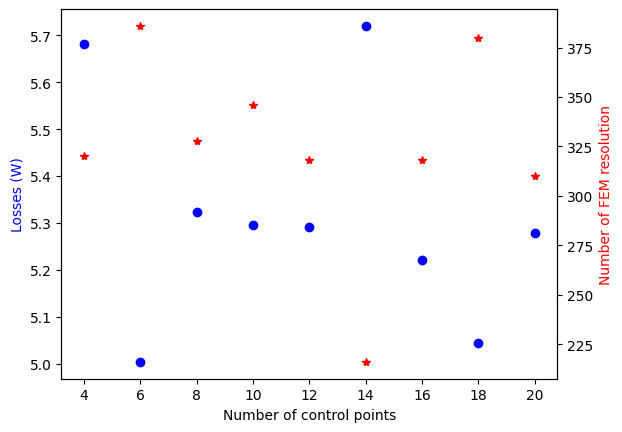

In [11]:
LossFinal = []
InductanceFinal = []
NFEMFinal = []
for iN in range(len(NControlPoints)):
    filename = "results/gradient_based_N"+ str(NControlPoints[iN]) +".pkl"
    with open(filename, "rb") as input_file:
        res = pickle.load(input_file)
    LossFinal.append(res["LossList"][-1])
    InductanceFinal.append(res["InductanceList"][-1])
    NFEMFinal.append(res["NFEM"])

ax1 = plt.plot(NControlPoints,LossFinal, 'o', color="b")
plt.ylabel("Losses (W)", color="b")
plt.xlabel("Number of control points")
ax2 = plt.gca().twinx()
ax2.plot(NControlPoints,NFEMFinal, '*', color="r")
plt.ylabel("Number of FEM resolution", color="r")
plt.show()

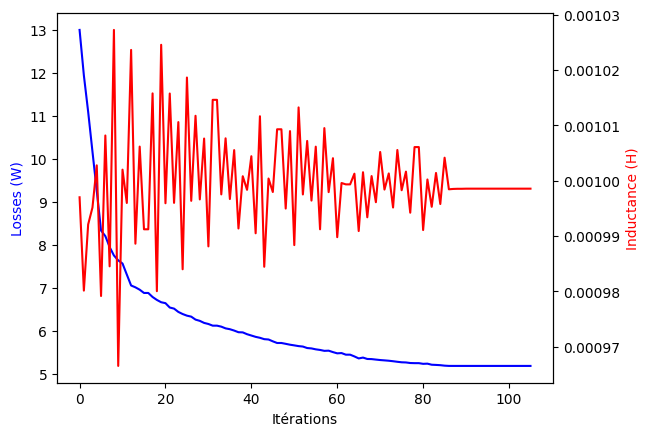

In [12]:
# Display convergence



ax1 = plt.plot(LossList, color="b")
plt.ylabel("Losses (W)", color="b")
plt.xlabel("Itérations")
ax2 = plt.gca().twinx()
ax2.plot(InductanceList, color="r")
plt.ylabel("Inductance (H)", color="r")
plt.show()


In [13]:
print(f"It : {len(InductanceList)} | P = {LossList[-1]:.2f} W | L = {InductanceList[-1]*1e3 :.2f} mH ")


It : 106 | P = 5.18 W | L = 1.00 mH 
